**OBJECTIVE:** To assess ViMuRe models on the 75 villages of Karnataka data.

**AUTHOR:** [@jonjoncardoso](https://github.com/jonjoncardoso) 

**LAST UPDATED:** 13/12/2021

**[DOWNLOAD DATA FROM HERE](https://drive.google.com/drive/folders/1-x_lPoryAE__ZeYH2XlhLT3r0QWQPDb_?usp=sharing)**


In [224]:
%load_ext autoreload
%autoreload 2

In [576]:
import tqdm
import functools
import matplotlib


from tqdm.notebook import tqdm_notebook

# Load this to be able to use df.groupby.progress_apply
tqdm_notebook.pandas()

import numpy as np
import scipy as sp
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt


import vimure as vm

from plotnine import * 
from mizani.formatters import percent_format

from vimure.log import setup_logging
logger = setup_logging("notebook04")

**CONSTANTS**

In [2]:
COLORS =  ['#E69F25', '#5CB4E4', '#069F72', '#F1E545', '#0773B2', '#CC79A8']

DATA_FOLDER = "/mnt/data/input/india_microfinance/formatted/"  # Folder contains structured CSV files

LAYERS = ["money", "advice", "kerorice", "visit"]

VILLAGE_IDs = list(range(1, 12+1)) + list(range(14, 21+1)) + list(range(23, 77+1))

In [4]:
# https://stackoverflow.com/a/59812588/843365
!export PYTHONUNBUFFERED=1

# How to run the experiments

To make it easier to parallelize our runs, I have created a python script, [karnataka.py](https://github.com/danielRedhead/latent_network_models/blob/develop/code/vimure/src/python/experiments/karnataka.py).

Follow the steps below to replicate the results of our experiments:

1. Go to vimure package folder

   ```shell
   cd latent_network_models/code/vimure
   ```


2. Open a shell inside the Docker container defined for this project:

```shell
docker-compose run --rm notebooks bash
```

Docker will automatically handle all python dependencies. For more info about Docker and the project's docker structure, please see the [dev README](https://github.com/danielRedhead/latent_network_models/blob/develop/code/vimure/README.md)

3. **ViMuRe:** run the script to a selected village. This will run ViMuRe 10 times with different pseudo-random seeds and return reciprocity values calculated from the latent network $\hat{Y}$ estimated by the algorithm. For example:

```shell
ipython3 experiments/karnataka.py -- --village vil1 
```



# What the script does

1. **Reads** the CSV file containing edgelists as informed by respondants. 

   CSV columns:

```shell
"respondent","i","j","type","weight"
```

2. **Compute `N`**, the number of nodes in the network as given by the union of IDs in the columns `respondent`, `i` and `j` <sup>[(link)](https://github.com/danielRedhead/latent_network_models/blob/develop/code/vimure/src/python/experiments/karnataka.py#L68)</sup>.

```python
    respondents = set(metadata[metadata["didsurv"] == 1]["pid"])
    nodes = respondents.union(set(edgelist["i"])).union(set(edgelist["j"]))
```

3. **Compute the reporter's mask `R`**: The binary tensor $R^l_{ijm}$ is used to inform which ties $(l,i,j)$ _can_ be reported by each reporter $m$ <sup>[(link)](https://github.com/danielRedhead/latent_network_models/blob/develop/code/vimure/src/python/vimure/io.py#L215)</sup>.

   - By design, reporters can only report on their own ties. Therefore $R^l_{ijm} = 0$ for all $m$ in which neither $i=m$ nor $j=m$.
   - The mask is also set to zero if a node $i$ does not appear in the column `respondent` at all. 
   
4. **Run ViMuRe**
   - num_realisations = 5
   - max_iter = 101
   - seeds = np.arange(1, 10)
   - K = 2

5. **Calculate the optimal threshold** as given by the equation: $t* = 0.54 \eta_{est} - 0.01$

```python
optimal_threshold = 0.54 * model.G_exp_nu - 0.01
```

6. **Binarize the output posterior $\rho$ variable** with the given threshold.

7. **Save a summary of the results** to directory `/mnt/data` sub-folder `output/real_data/karnataka_villages`:

- `vimure_model_summary.csv`:  
    - running_time
    - num_realisations
    - max_iter
    - initial_seed
    - best_seed
    - best_elbo
    - eta_est
    - lambda_k
    - model
    - village
    - layer
- `vimure_model_edgelist.csv`: 
    - village
    - layer
    - source,
    - target
    - dyad_ID
    - source_reliability
    - target_reliability
    - source_report
    - target_report
    - vimure_posterior_probability
    - in_union
    - in_intersection
    - in_vimure
    - reciprocated_in_union
    - reciprocated_in_intersection
    - reciprocated_in_vimure
- `vimure_model_trace.csv`: 
    - realisation
    - seed
    - iter
    - elbo
    - runtime
    - reached_convergence
    - model
    - village
    - layer


## (optional reading) Some information on the `/mnt/data` directory

This `/mnt/data` exists inside the Docker container but it is also mapped to a directory in your computer. If you would like to change it to a different folder (maybe you like to store experiment outputs elsewhere), stop the Docker container that is running this notebook, edit the text file [\<latent-network-models\>/code/vimure/docker-compose.yml](https://github.com/danielRedhead/latent_network_models/blob/develop/code/vimure/docker-compose.yml#L13) to point to a different path and re-run the container.

For example, if you are on Windows and you would like to store results on D:/data, change it to:

```yml
version: "3.5"

services:

  notebooks:
    ...
    volumes:
    D:/data:/mnt/data/
    ...
```

# Read results

## Summary

In [225]:
df_model_summary = pd.read_csv("/mnt/data/output/real_data/karnataka_villages/vimure_model_summary.csv")
df_model_summary.head()

,running_time,num_realisations,max_iter,initial_seed,best_seed,best_elbo,eta_est,lambda_k,model,village,layer
0,96.488805,5,101,0,1322,233.476071,0.430103,"[0.00020367489978655648, 1.0780469026953665]",ViMuRe_T,vil5,advice
1,82.103140,5,101,0,1322,673.970544,0.907556,"[0.0004887062703898974, 0.6498638972671734]",ViMuRe_T,vil5,kerorice
2,155.552401,5,101,0,1160,411.604253,0.558017,"[0.00012160491421425192, 0.9491118781680927]",ViMuRe_T,vil2,advice
3,180.334863,5,101,0,1335,223.752558,0.431011,"[0.00011599049368699774, 1.0169149310701315]",ViMuRe_T,vil1,advice
4,81.744688,5,101,0,1322,440.015299,0.727716,"[0.0002425453316118268, 0.9538215061483349]",ViMuRe_T,vil5,money


In [226]:
df_model_summary["village"].nunique()

75

**What is the average running time per village?**

In [227]:
df_model_summary["running_time"].describe().to_frame().T

,count,mean,std,min,25%,50%,75%,max
running_time,3052.0,267.919012,222.253327,28.851891,128.214798,209.166987,344.949747,3702.800847


<AxesSubplot:>

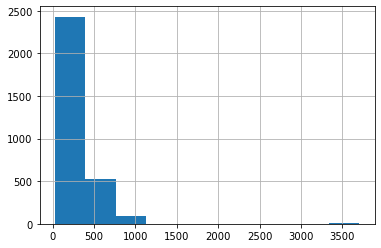

In [228]:
df_model_summary["running_time"].hist()

In [229]:
import itertools

all_combinations = pd.DataFrame([[f"vil{village}", layer, seed] 
                                 for village in VILLAGE_IDs 
                                 for layer in LAYERS 
                                 for seed in np.arange(10)], 
                                columns=["village", "layer", "seed"])
all_combinations.shape

(3000, 3)

Which villages are still missing?

In [230]:
pd.merge(all_combinations, df_model_summary, how="left").groupby(["village"])\
    .apply(lambda x: pd.Series({"n_runs": x["initial_seed"].nunique()}))\
    .query("n_runs == 0").reset_index()["village"].values

array([], dtype=object)

Which villages have incomplete results/are running?

In [231]:
df_model_summary.groupby(["village", "layer"])\
    .apply(lambda x: pd.Series({"n_runs": x["initial_seed"].nunique()}))\
    .query("n_runs != 0 & n_runs != 10")

,,n_runs
village,layer,


## Select best ELBOs per village+layer

In [157]:
best_seeds =\
    df_model_summary.sort_values(by=["best_elbo"], ascending=False)\
    .groupby(["village", "layer"]).first()[["initial_seed"]]\
    .reset_index()
best_seeds.head()

,village,layer,initial_seed
0,vil1,advice,4
1,vil1,kerorice,6
2,vil1,money,9
3,vil1,visit,3
4,vil10,advice,7


In [158]:
df_model_summary = pd.merge(best_seeds, df_model_summary, how="left")

## Model Trace

In case you want to inspect how ELBO values changed after every few iterations of the algorithm

In [161]:
df_model_trace = pd.read_csv("/mnt/data/output/real_data/karnataka_villages/vimure_model_trace.csv")

# Example of info
df_model_trace.query("village == 'vil5' & layer == 'advice'").set_index(["village", "model", "layer", "realisation", "seed", "iter"])

elbo   runtime  \
village model    layer  realisation seed iter                         
vil5    ViMuRe_T advice 0           0    0    -796.030926  0.246507   
                                         10    225.516247  0.243141   
                                         20    232.361554  0.228754   
                                         30    233.279461  0.224750   
                                         40    233.438671  0.218385   
...                                                   ...       ...   
                        4           1198 20    232.996703  0.295083   
                                         30    233.902618  0.286705   
                                         40    234.059928  0.329824   
                                         50    234.090359  0.287198   
                                         60    234.096971  0.279260   

                                               reached_convergence  
village model    layer  realisation seed iter                       
vil5    ViMuRe_T advice 0           0    0                   False  
                                         10                  False  
                                         20                  False  
                                         30                  False  
                                         40                  False  
...                                                            ...  
                        4           1198 20                  False  
                                         30                  False  
                                         40                  False  
                                         50                  False  
                                         60                   True  

[350 rows x 3 columns]

array([[<AxesSubplot:title={'center':'avg_runtime_per_iteration'}>]],
      dtype=object)

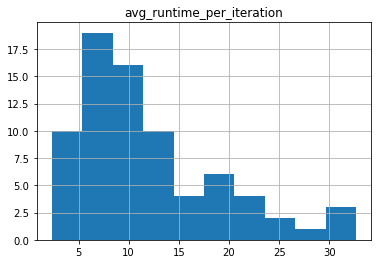

In [165]:
df_model_trace.groupby(["village"]).apply(lambda x: pd.Series({"avg_runtime_per_iteration": x["runtime"].sum()/x["iter"].max()}))\
    .sort_values("avg_runtime_per_iteration", ascending=False).hist()

## Edgelist

In [166]:
df_model_edgelist = pd.read_csv("/mnt/data/output/real_data/karnataka_villages/vimure_model_edgelist.csv")
df_model_edgelist = pd.merge(best_seeds, df_model_edgelist, how="left")

df_model_edgelist.head()

,village,layer,initial_seed,source,target,dyad_ID,source_report,target_report,vimure_posterior_probability,in_union,in_intersection,in_vimure,reciprocated_in_union,reciprocated_in_intersection,reciprocated_in_vimure
0,vil1,advice,4,0,107,0_107,True,False,0.999553,True,False,True,False,False,False
1,vil1,advice,4,1,107,1_107,True,False,0.999773,True,False,True,False,False,False
2,vil1,advice,4,4,3,4_3,True,True,1.000000,True,True,True,False,False,False
3,vil1,advice,4,4,116,4_116,False,True,0.999628,True,False,True,False,False,False
4,vil1,advice,4,4,265,4_265,True,False,0.999654,True,False,True,False,False,False


In [167]:
pd.crosstab(df_model_edgelist["source_report"], df_model_edgelist["target_report"])

target_report,False,True
source_report,,
False,0,135140
True,147239,15315


## Reliability

In [168]:
df_reliability = pd.read_csv("/mnt/data/output/real_data/karnataka_villages/vimure_model_reliability.csv")
df_reliability = pd.merge(best_seeds, df_reliability, how="left")

df_reliability

,village,layer,initial_seed,node,theta,lambda_theta,is_node_reporter
0,vil1,advice,4,0,0.725677,0.737093,True
1,vil1,advice,4,1,0.725594,0.737009,True
2,vil1,advice,4,2,0.000297,0.000302,False
3,vil1,advice,4,3,0.725526,0.736940,True
4,vil1,advice,4,4,0.498714,0.506560,True
...,...,...,...,...,...,...,...
144427,vil9,visit,2,518,0.000297,0.000243,False
144428,vil9,visit,2,519,0.000297,0.000243,False
144429,vil9,visit,2,520,0.000007,0.000006,True
144430,vil9,visit,2,521,0.201728,0.165146,True


In [169]:
df_reliability.groupby(["layer", "is_node_reporter"])[["lambda_theta"]].describe()

lambda_theta                                    \
                                 count      mean       std           min   
layer    is_node_reporter                                                  
advice   False                 18678.0  0.000299  0.000042  2.069036e-04   
         True                  16983.0  0.414658  0.303334  4.981959e-07   
kerorice False                 18678.0  0.000231  0.000060  1.116907e-04   
         True                  16983.0  0.260180  0.308756  1.491360e-06   
money    False                 19138.0  0.000264  0.000051  1.417863e-04   
         True                  17417.0  0.328649  0.313931  1.429354e-06   
visit    False                 19138.0  0.000239  0.000069  1.244124e-04   
         True                  17417.0  0.269120  0.307074  1.459272e-06   

                                                                   
                                25%       50%       75%       max  
layer    is_node_reporter                                          
advice   False             0.000270  0.000302  0.000322  0.000442  
         True              0.000029  0.502470  0.691107  0.930267  
kerorice False             0.000186  0.000225  0.000272  0.000379  
         True              0.000009  0.000022  0.533880  0.927919  
money    False             0.000235  0.000267  0.000289  0.000419  
         True              0.000013  0.320676  0.614385  0.928349  
visit    False             0.000186  0.000225  0.000286  0.000407  
         True              0.000007  0.000033  0.546481  0.928344

In [13]:
df_model_summary = pd.merge(best_seeds, df_model_summary, how="left")

## Number of reporters per (village, layer)

In [170]:
# Stores the number of reporters per village+layer

num_reporters = df_reliability[["village", "layer", "node", "is_node_reporter"]].drop_duplicates()\
    .groupby(["village", "layer"])["is_node_reporter"].sum()
num_reporters.head()

village  layer   
vil1     advice      203
         kerorice    203
         money       203
         visit       203
vil10    advice       95
Name: is_node_reporter, dtype: int64

# Compare network statistics

## Build a useful DataFrame

First, let us create a separate DataFrame to include missing nodes. We will represent those as self-loops just so [`nx.from_pandas_edgelist`](https://networkx.org/documentation/stable/reference/generated/networkx.convert_matrix.from_pandas_edgelist.html) can infer the right number of nodes.


Fist, create an expanded DataFrame to include all nodes in (in_union, in_intersection, in_vimure)

In [171]:
cols = ["village", "layer", "initial_seed", "node", "is_node_reporter"]

df_expanded = df_reliability[cols].drop_duplicates()
df_expanded["in_union"] = True
df_expanded["in_intersection"] = True
df_expanded["in_vimure"] = True

Now, let us create a bigger edgelist, one that includes self-loops and a column indicating whether a source/target is flagged as a reporter in the original dataset:

In [172]:
df_bigger_edgelist = df_model_edgelist[["village", 
                                         "layer", 
                                         "initial_seed", 
                                         "source", 
                                         "target", 
                                         "in_union", 
                                         "in_intersection", 
                                         "in_vimure"]].copy()


## aux_df1 represents self-loops source-source
aux_df1 = pd.merge(df_expanded.rename(columns={"node": "source", "is_node_reporter": "is_source_reporter"}), 
                   df_bigger_edgelist, 
                   how="left")
aux_df1 = aux_df1[aux_df1["target"].isnull()].copy()
aux_df1["is_source_reporter"].fillna(False, inplace=True)
aux_df1["is_target_reporter"] = aux_df1["is_source_reporter"]
aux_df1["in_union"] = True
aux_df1["in_intersection"] = True
aux_df1["in_vimure"] = True
aux_df1["target"] = aux_df1["source"]
aux_df1["weight"] = 0

## aux_df2 represents self-loops target-target
aux_df2 = pd.merge(df_expanded.rename(columns={"node": "target", "is_node_reporter": "is_target_reporter"}), 
                   df_bigger_edgelist, 
                   how="left")
aux_df2 = aux_df2[aux_df2["source"].isnull()].copy()
aux_df2["is_target_reporter"].fillna(False, inplace=True)
aux_df2["is_source_reporter"] = aux_df2["is_target_reporter"]
aux_df2["in_union"] = True
aux_df2["in_intersection"] = True
aux_df2["in_vimure"] = True
aux_df2["source"] = aux_df2["target"]
aux_df2["weight"] = 0


## aux_df3 simply adds the columns `is_source_reporter` and `is_target_reporter` to the original edgelist
aux_df3 = pd.merge(df_bigger_edgelist,
                   df_expanded[["village", "layer", "initial_seed", "node",  "is_node_reporter"]]\
                       .rename(columns={"node": "target", "is_node_reporter": "is_target_reporter"}),  
                   how="left")
aux_df3["is_target_reporter"].fillna(False, inplace=True)

aux_df3 = pd.merge(aux_df3,
                   df_expanded[["village", "layer", "initial_seed", "node",  "is_node_reporter"]]\
                       .rename(columns={"node": "source", "is_node_reporter": "is_source_reporter"}),  
                   how="left")
aux_df3["is_source_reporter"].fillna(False, inplace=True)
aux_df3["weight"] = 1

df_bigger_edgelist = pd.concat([aux_df3, aux_df1, aux_df2])

del aux_df1, aux_df2, aux_df3

In [44]:
df_bigger_edgelist.groupby(["is_source_reporter", "is_target_reporter", "in_union", "in_vimure"])\
    .apply(lambda x: pd.Series({"num_ties": len(x)}))

num_ties
is_source_reporter is_target_reporter in_union in_vimure          
False              False              True     True         114800
                   True               True     False         10076
                                               True          43816
True               False              True     False          9893
                                               True          47191
                   True               True     False         29515
                                               True         170104

## Calculate networks stats

Union vs Intersection vs Vimure

array([[<AxesSubplot:title={'center':'avg_runtime'}>]], dtype=object)

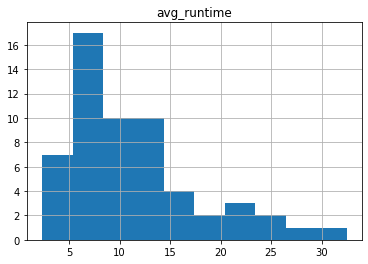

In [174]:
def get_net_stats_df(G, aggregation_name):
    # Avg number of nominations (outgoing edges) per reporter
    out_degrees = [d for _, d in G.out_degree()]
    avg_out_degree = np.mean(out_degrees)

    return pd.DataFrame({"aggregation":     aggregation_name,
                         "num_nodes": G.number_of_nodes(),
                         "num_edges":       G.number_of_edges(),
                         "num_strongly_components":   nx.number_strongly_connected_components(G),
                         "num_weakly_components":   nx.number_weakly_connected_components(G),
                         "avg_out_degree":  avg_out_degree,
                         "transitivity" :   nx.transitivity(G),
                         "reciprocity"  :   nx.overall_reciprocity(G)
                        },
                        index=[0]) 

def compare_net_stats(df_edgelist, models=["in_union", "in_intersection", "in_vimure"]):

    village = df_edgelist["village"].values[0]
    layer = df_edgelist["layer"].values[0]    
    
    relevant_columns = ["source", "target", "weight"]
    
    filtered_edgelist = df_edgelist[(df_edgelist["is_source_reporter"] & df_edgelist["is_target_reporter"])]

    all_dfs = []
    
    
    if models is None:
        G = nx.from_pandas_edgelist(filtered_edgelist[relevant_columns], create_using=nx.DiGraph)
        G.remove_edges_from(nx.selfloop_edges(G))
        df = get_net_stats_df(G, aggregation_name=layer)        
        
        all_dfs.append(df)
        
    else:
        
        if "in_union" in models:
            # Filter to include only within sample 
            tmp = filtered_edgelist[(filtered_edgelist["in_union"])]
            G_union = nx.from_pandas_edgelist(tmp[relevant_columns], create_using=nx.DiGraph)
            G_union.remove_edges_from(nx.selfloop_edges(G_union))
            df_union = get_net_stats_df(G_union, aggregation_name="union")
            
            all_dfs.append(df_union)
    
        if "in_intersection" in models:
            # Filter to include only within sample 
            tmp = filtered_edgelist[(filtered_edgelist["in_intersection"])]
            G_intersection = nx.from_pandas_edgelist(tmp[relevant_columns], create_using=nx.DiGraph)
            G_intersection.remove_edges_from(nx.selfloop_edges(G_intersection))
            df_intersection = get_net_stats_df(G_intersection, aggregation_name="intersection")
            
            all_dfs.append(df_intersection)
    
        if "in_vimure" in models:
            # Vimure takes full sample into account 
            tmp = filtered_edgelist[(filtered_edgelist["in_vimure"])]
            G_vimure = nx.from_pandas_edgelist(tmp[relevant_columns], create_using=nx.DiGraph)
            G_vimure.remove_edges_from(nx.selfloop_edges(G_vimure))
            df_vimure = get_net_stats_df(G_vimure, aggregation_name="vimure")
            
            all_dfs.append(df_vimure)
    
    return pd.concat(all_dfs)

In [175]:
from experiments.karnataka import read_village_data

def get_df_original_layer(village):
    edgelist, nodes, reporters = read_village_data(village=village, ties_layer_mapping=None, data_folder=DATA_FOLDER, print_details=True)

    edgelist.rename(columns={"Ego": "source", "Alter": "target"}, inplace=True)
    edgelist["initial_seed"] = -1
    edgelist["village"] = village
    edgelist["is_source_reporter"] = edgelist["source"].apply(lambda x: x in reporters)
    edgelist["is_target_reporter"] = edgelist["target"].apply(lambda x: x in reporters)
    return edgelist

df_original_layers_stats = pd.concat([get_df_original_layer(f"vil{int(village)}") for village in tqdm.tqdm(VILLAGE_IDs)])

100%|██████████| 75/75 [00:04<00:00, 18.65it/s]


# Calculate network statistics

In [233]:
df_reliability = pd.read_csv("/mnt/data/output/real_data/karnataka_villages/vimure_model_reliability.csv")
df_reliability = pd.merge(best_seeds, df_reliability, how="left")

df_reliability

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/600 [00:00<?, ?it/s]

In [20]:
# Get network statistics from df_model_edgelist
plot_df = pd.concat([
    df_bigger_edgelist.groupby(["village", "layer", "initial_seed"]).progress_apply(compare_net_stats),
    df_original_layers_stats.groupby(["village", "layer", "initial_seed"]).progress_apply(lambda x: compare_net_stats(x, models=None))])
plot_df.reset_index(inplace=True)
plot_df.drop(columns="level_3", inplace=True) # Remove phantom column


ties_layer_mapping={
        "borrowmoney": "money",
        "receivemoney": "money",
        "receiveadvice": "advice",
        "helpdecision": "advice",
        "keroricego": "kerorice",
        "keroricecome": "kerorice",
        "visitgo": "visit",
        "visitcome": "visit",
    }

ties_model_mapping={
        "borrowmoney": "Incoming",
        "receivemoney": "Outgoing",
        "receiveadvice": "Incoming",
        "helpdecision": "Outgoing",
        "keroricego": "Incoming",
        "keroricecome": "Outgoing",
        "visitgo": "Incoming",
        "visitcome": "Outgoing",
    }

plot_df["aggregation"] = plot_df.apply(lambda x: ties_model_mapping[x["layer"]] if x["layer"] in ties_model_mapping.keys() else x["aggregation"], axis=1)
plot_df["layer"] = plot_df["layer"].apply(lambda x: ties_layer_mapping[x] if x in ties_layer_mapping.keys() else x)

# Preprocess columns for plots
plot_df["layer"] = pd.Categorical(plot_df["layer"], categories=["advice", "money", "visit", "kerorice"], ordered=True)
plot_df["layer"].cat.rename_categories({"advice": "Advice", "money": "Money", "visit": "Visit", "kerorice": "HH Items"}, inplace=True)

plot_df["reciprocity"] = plot_df["reciprocity"].astype(float)

plot_df["model"] = pd.Categorical(plot_df["aggregation"], categories=["intersection", "union", "vimure", "Incoming", "Outgoing"])
plot_df["model"] = plot_df["model"].cat.rename_categories({ "vimure": r"$ViMuRe_{T}$"})


plot_df

,village,layer,initial_seed,aggregation,num_nodes,num_edges,num_strongly_components,num_weakly_components,avg_out_degree,transitivity,reciprocity,model
0,vil1,Advice,4,union,203,341,93,28,1.679803,0.142157,0.463343,union
1,vil1,Advice,4,intersection,203,19,198,189,0.093596,0.000000,0.526316,intersection
2,vil1,Advice,4,vimure,203,319,110,28,1.571429,0.133333,0.407524,$ViMuRe_{T}$
3,vil1,HH Items,6,union,203,360,71,38,1.773399,0.051148,0.811111,union
4,vil1,HH Items,6,intersection,203,19,196,191,0.093596,0.000000,0.736842,intersection
...,...,...,...,...,...,...,...,...,...,...,...,...
1495,vil9,HH Items,-1,Incoming,198,231,170,12,1.166667,0.143836,0.181818,Incoming
1496,vil9,Advice,-1,Incoming,192,187,174,31,0.973958,0.033708,0.171123,Incoming
1497,vil9,Money,-1,Outgoing,184,190,173,23,1.032609,0.065421,0.115789,Outgoing
1498,vil9,Visit,-1,Outgoing,204,246,181,13,1.205882,0.061275,0.170732,Outgoing


In [180]:
summary = \
    plot_df.groupby(["layer", "aggregation"])\
        .progress_apply(lambda x: pd.Series({
                                    "num_edges": f"$ {x['num_edges'].mean():.2f} \pm {x['num_edges'].std():.2f}$",
                                    "mean_degree": f"$ {x['avg_out_degree'].mean():.2f} \pm {x['avg_out_degree'].std():.2f}$",
                                    "transitivity": f"$ {x['transitivity'].mean():.2f} \pm {x['transitivity'].std():.2f}$",
                                    "reciprocity": f"$ {x['reciprocity'].mean():.2f} \pm {x['reciprocity'].std():.2f}$"}))
summary

  0%|          | 0/20 [00:00<?, ?it/s]

num_nodes             num_edges  \
layer    aggregation                                               
Advice   Incoming      $ 184.96 \pm 61.00$   $ 195.96 \pm 71.39$   
         Outgoing      $ 199.72 \pm 62.28$   $ 243.04 \pm 83.92$   
         intersection  $ 226.44 \pm 70.61$    $ 44.69 \pm 23.51$   
         union         $ 226.44 \pm 70.61$  $ 394.31 \pm 137.06$   
         vimure        $ 226.44 \pm 70.61$  $ 343.57 \pm 117.39$   
Money    Incoming      $ 191.28 \pm 62.67$  $ 249.03 \pm 102.08$   
         Outgoing      $ 182.01 \pm 61.27$   $ 217.53 \pm 88.44$   
         intersection  $ 226.44 \pm 70.61$    $ 37.43 \pm 19.56$   
         union         $ 226.44 \pm 70.61$  $ 429.13 \pm 174.32$   
         vimure        $ 226.44 \pm 70.61$  $ 322.17 \pm 135.20$   
Visit    Incoming      $ 206.44 \pm 67.16$  $ 344.25 \pm 142.18$   
         Outgoing      $ 205.15 \pm 66.73$  $ 328.99 \pm 133.76$   
         intersection  $ 226.44 \pm 70.61$    $ 63.97 \pm 31.70$   
         union         $ 226.44 \pm 70.61$  $ 609.27 \pm 249.48$   
         vimure        $ 226.44 \pm 70.61$  $ 389.60 \pm 189.50$   
HH Items Incoming      $ 196.76 \pm 63.80$  $ 289.08 \pm 118.49$   
         Outgoing      $ 196.51 \pm 63.01$  $ 281.43 \pm 111.24$   
         intersection  $ 226.44 \pm 70.61$    $ 54.67 \pm 29.97$   
         union         $ 226.44 \pm 70.61$  $ 515.84 \pm 204.45$   
         vimure        $ 226.44 \pm 70.61$  $ 350.68 \pm 159.07$   

                            mean_degree      transitivity       reciprocity  
layer    aggregation                                                         
Advice   Incoming      $ 1.05 \pm 0.11$  $ 0.04 \pm 0.02$  $ 0.22 \pm 0.09$  
         Outgoing      $ 1.21 \pm 0.16$  $ 0.14 \pm 0.06$  $ 0.20 \pm 0.08$  
         intersection  $ 0.20 \pm 0.09$  $ 0.06 \pm 0.16$  $ 0.45 \pm 0.18$  
         union         $ 1.74 \pm 0.26$  $ 0.11 \pm 0.04$  $ 0.50 \pm 0.11$  
         vimure        $ 1.52 \pm 0.21$  $ 0.11 \pm 0.03$  $ 0.39 \pm 0.07$  
Money    Incoming      $ 1.28 \pm 0.20$  $ 0.13 \pm 0.06$  $ 0.15 \pm 0.05$  
         Outgoing      $ 1.18 \pm 0.17$  $ 0.05 \pm 0.03$  $ 0.16 \pm 0.05$  
         intersection  $ 0.17 \pm 0.07$  $ 0.06 \pm 0.14$  $ 0.58 \pm 0.17$  
         union         $ 1.88 \pm 0.39$  $ 0.11 \pm 0.05$  $ 0.64 \pm 0.09$  
         vimure        $ 1.40 \pm 0.29$  $ 0.09 \pm 0.04$  $ 0.43 \pm 0.08$  
Visit    Incoming      $ 1.64 \pm 0.30$  $ 0.16 \pm 0.06$  $ 0.19 \pm 0.05$  
         Outgoing      $ 1.58 \pm 0.27$  $ 0.07 \pm 0.03$  $ 0.19 \pm 0.05$  
         intersection  $ 0.28 \pm 0.11$  $ 0.14 \pm 0.17$  $ 0.70 \pm 0.16$  
         union         $ 2.66 \pm 0.59$  $ 0.13 \pm 0.05$  $ 0.76 \pm 0.10$  
         vimure        $ 1.69 \pm 0.49$  $ 0.11 \pm 0.04$  $ 0.47 \pm 0.07$  
HH Items Incoming      $ 1.45 \pm 0.24$  $ 0.19 \pm 0.07$  $ 0.20 \pm 0.05$  
         Outgoing      $ 1.41 \pm 0.22$  $ 0.07 \pm 0.03$  $ 0.18 \pm 0.05$  
         intersection  $ 0.24 \pm 0.11$  $ 0.19 \pm 0.22$  $ 0.72 \pm 0.16$  
         union         $ 2.26 \pm 0.46$  $ 0.14 \pm 0.05$  $ 0.74 \pm 0.12$  
         vimure        $ 1.53 \pm 0.38$  $ 0.11 \pm 0.05$  $ 0.48 \pm 0.08$

In [179]:
print(summary.to_latex().replace("\\textbackslash pm", "\\pm").replace("\\$", "$"))

\begin{tabular}{llllll}
\toprule
         &        &             num\_edges &       mean\_degree &      transitivity &       reciprocity \\
layer & aggregation &                       &                   &                   &                   \\
\midrule
Advice & Incoming &   $ 195.96 \pm 71.39$ &  $ 1.05 \pm 0.11$ &  $ 0.04 \pm 0.02$ &  $ 0.22 \pm 0.09$ \\
         & Outgoing &   $ 243.04 \pm 83.92$ &  $ 1.21 \pm 0.16$ &  $ 0.14 \pm 0.06$ &  $ 0.20 \pm 0.08$ \\
         & intersection &    $ 44.69 \pm 23.51$ &  $ 0.20 \pm 0.09$ &  $ 0.06 \pm 0.16$ &  $ 0.45 \pm 0.18$ \\
         & union &  $ 394.31 \pm 137.06$ &  $ 1.74 \pm 0.26$ &  $ 0.11 \pm 0.04$ &  $ 0.50 \pm 0.11$ \\
         & vimure &  $ 343.57 \pm 117.39$ &  $ 1.52 \pm 0.21$ &  $ 0.11 \pm 0.03$ &  $ 0.39 \pm 0.07$ \\
Money & Incoming &  $ 249.03 \pm 102.08$ &  $ 1.28 \pm 0.20$ &  $ 0.13 \pm 0.06$ &  $ 0.15 \pm 0.05$ \\
         & Outgoing &   $ 217.53 \pm 88.44$ &  $ 1.18 \pm 0.17$ &  $ 0.05 \pm 0.03$ &  $ 0.16 \pm 0.05$ \\
 

# Visualize single network

Taking (vil55 visit) as an example

In [234]:
plot_df.groupby(["village", "layer"]).apply(lambda x: pd.Series({"major_diff": x[x["aggregation"] == "union"]["avg_out_degree"].values[0] - 
                                                                 x[x["aggregation"] == "vimure"]["avg_out_degree"].values[0]})).sort_values("major_diff", ascending=False)

,,major_diff
village,layer,
vil35,Visit,1.773148
vil55,Visit,1.759857
vil41,Visit,1.657459
vil44,Visit,1.627907
vil37,Visit,1.568182
...,...,...
vil67,Advice,0.047619
vil12,Advice,0.046154
vil26,Advice,0.026846


In [243]:
df_reliability.query("village == 'vil55' and layer == 'visit'")["is_node_reporter"].value_counts()

False    296
True     279
Name: is_node_reporter, dtype: int64

In [238]:
plot_df.query("village == 'vil55' & layer== 'Visit'")

,village,layer,initial_seed,aggregation,num_nodes,num_edges,num_strongly_components,num_weakly_components,avg_out_degree,transitivity,reciprocity,model
585,vil55,Visit,9,union,279,878,16,12,3.146953,0.174211,0.933941,union
586,vil55,Visit,9,intersection,279,147,213,202,0.526882,0.175676,0.884354,intersection
587,vil55,Visit,9,vimure,279,387,156,54,1.387097,0.094276,0.490956,$ViMuRe_{T}$
1290,vil55,Visit,-1,Outgoing,268,506,163,1,1.888060,0.101408,0.284585,Outgoing
1291,vil55,Visit,-1,Incoming,266,519,149,2,1.951128,0.221910,0.285164,Incoming


In [ ]:
# df_model_edgelist[(df_model_edgelist["village"] == "vil55") & (df_model_edgelist["layer"] == "visit")].to_csv("/mnt/data/output/real_data/karnataka_villages/vil55_visit_edgelist.csv", index=False)

# Read on Gephi -> Play around with positions and save it as a GML file

In [235]:
G = nx.read_gml("/mnt/data/output/real_data/karnataka_villages/vill55_visit.gml")

# pos = nx.fruchterman_reingold_layout(G)

pos = {node: np.array([node_attrs["graphics"]["x"], node_attrs["graphics"]["y"]]) 
       for node, node_attrs in G.nodes(data=True)}

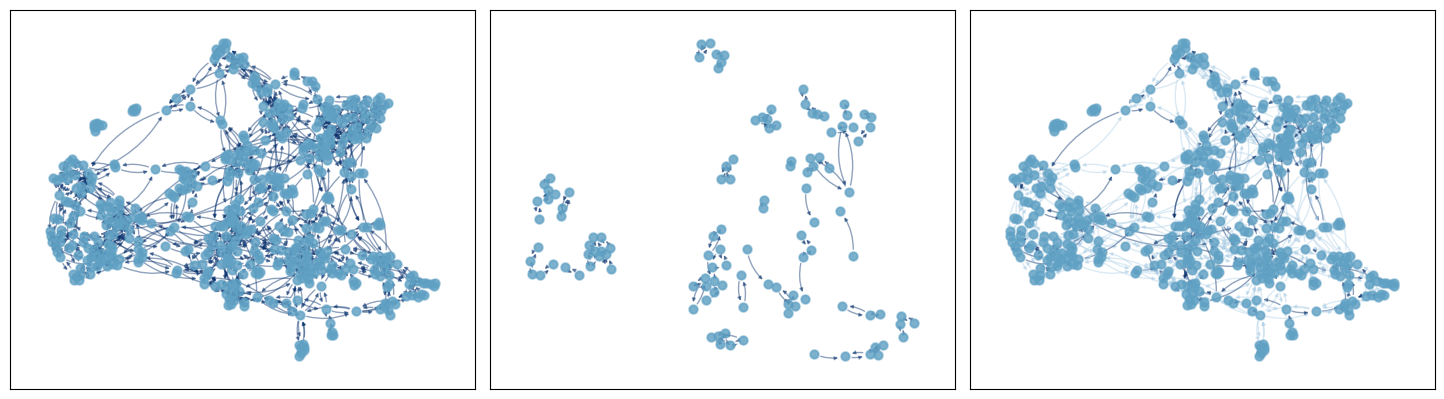

In [523]:
is_subplot = True # Set it to True to have just a single image
is_save = False

if is_subplot:
    plt.figure(figsize = (16/1.1, 4.5/1.1), dpi = 100)
    plt.axis('off')
    

idx = 1
for model in ["in_union", "in_intersection", "in_vimure"]:

    edges_to_show = [(edge[0], edge[1]) for edge in G.edges(data=True) 
                     if edge[2][model] == 'true' or model == "in_vimure"]
    selected_nodes = functools.reduce(lambda x, y: set(x).union(set(y)), edges_to_show)

    if model == "in_vimure":
        edgecolors = [float(G.edges[(edge[0], edge[1])]["vimure_posterior_probability"]) for edge in edges_to_show]
    else:
        edgecolors = "#08326E"
    
    if is_subplot:
        plt.subplot(1, 3, idx)
    else:
        plt.figure(figsize = (16/2, 12/2), dpi = 120)
        plt.axis('off')
        
        
    nx.draw_networkx_edges(G, node_size=100, pos=pos, label=False, 
                           edgelist=edges_to_show, 
                           edge_cmap=matplotlib.colors.ListedColormap(['#B0D1E7', '#08326E']),#(['#A7CEE4', '#0E3E84']),
                           arrowsize=5, connectionstyle='arc3,rad=0.2', alpha=0.45,
                           width=1,
                           edge_color=edgecolors,
                           arrows=True
                          )

    nx.draw_networkx_nodes(G, pos, nodelist=selected_nodes, node_size=48, label=None, node_color='#60A1C4', alpha=0.3)
    nx.draw_networkx_nodes(G, pos, nodelist=selected_nodes, node_size=32, label=None, node_color='#60A1C4', alpha=0.75) #60A1C4
    idx += 1
               
    if not is_subplot:
        plt.tight_layout()
        if is_save:
            plt.savefig(f"/mnt/data/output/real_data/karnataka_villages/vil55_visit_{model.replace('in_', '')}.png",
                        bbox_inches="tight", pad_inches = 0)
        plt.show()
               
    
if is_subplot:
    plt.tight_layout()    
    if is_save:
        plt.savefig(f"/mnt/data/output/real_data/karnataka_villages/vil55_visit_comparison.png",
                    bbox_inches="tight", pad_inches = 0)
    plt.show() # display

# Plot: compare networks' reciprocity

From here on, we don't need to plot the original layers:

In [258]:
plot_df = plot_df[plot_df["model"].isin(["intersection", "union", r"$ViMuRe_{T}$"])].copy()

## Annotate $\eta_{est}$ in the plot

In [259]:
annotation_df = df_model_summary.groupby(["layer"])["eta_est"].describe()[["mean", "std"]].reset_index()
annotation_df["layer"] = pd.Categorical(annotation_df["layer"], categories=["advice", "money", "visit", "kerorice"], ordered=True)
annotation_df["layer"].cat.rename_categories({"advice": "Advice", "money": "Money", "visit": "Visit", "kerorice": "HH Items"}, inplace=True)

# Fixed values -- used just to position the annotation in the plot
annotation_df["model"] = "union"
annotation_df["reciprocity"] = 0.95
annotation_df["eta_annotation"] = annotation_df.apply(lambda x: r"$\eta_{est} = %.2f \pm %.2f$" % (x["mean"], x["std"]), axis=1) 

annotation_df["layer"].cat.rename_categories({"advice": "Advice", "money": "Money", "visit": "Visit", "kerorice": "HH Items"}, inplace=True)
annotation_df

,layer,mean,std,model,reciprocity,eta_annotation
0,Advice,0.418764,0.096442,union,0.95,$\eta_{est} = 0.42 \pm 0.10$
1,HH Items,0.705893,0.119489,union,0.95,$\eta_{est} = 0.71 \pm 0.12$
2,Money,0.610602,0.099604,union,0.95,$\eta_{est} = 0.61 \pm 0.10$
3,Visit,0.717210,0.115922,union,0.95,$\eta_{est} = 0.72 \pm 0.12$


In [44]:
df_bigger_edgelist.groupby(["is_source_reporter", "is_target_reporter", "in_union", "in_vimure"])\
    .apply(lambda x: pd.Series({"num_ties": len(x)}))

num_ties
is_source_reporter is_target_reporter in_union in_vimure          
False              False              True     True         114800
                   True               True     False         10076
                                               True          43816
True               False              True     False          9893
                                               True          47191
                   True               True     False         29515
                                               True         170104

## The plot

In [260]:
def plot_network_stat(plot_df, statistic="reciprocity", annotation_df=None):

    g = (ggplot(plot_df, 
                aes(x="model", 
                    y=statistic,
                    fill="model")) +
         geom_boxplot(position="dodge", alpha=0.9) + 
         scale_fill_manual(name="Model Type",
                           values={"union": "gold",
                                   "intersection": "mediumseagreen",
                                   r"$ViMuRe_{T}$": "dodgerblue"},
                          guide=False) +
         theme_bw() + 
         theme(figure_size=(15, 4.5),
               axis_text_x=element_text(rotation=90, margin={'b': 30, 'r': 5}, size=13),
               axis_text_y=element_text(size=12),
               panel_grid_minor=element_blank(),
               panel_grid_major_x=element_blank(),
               panel_grid_major_y=element_rect(alpha=0.5),
               strip_background = element_blank(),
               strip_text_x = element_text(size=10),
               axis_title_y=element_text(size=18),
               legend_position = (9, 0.6),
               legend_background = element_rect(fill = "white", colour = None),
               legend_direction="vertical") +
         scale_x_discrete(name="", breaks=["intersection", "union", r"$ViMuRe_{T}$"]) +
         facet_grid("~ layer", labeller="label_value") + 
        ggtitle(f"[{statistic.upper()}] results for %d villages" % plot_df["village"].nunique()))
    
    if annotation_df is not None:
        g = g + geom_text(aes(label="eta_annotation"), data=annotation_df, ha="left", size=11, color="black")
        
    if statistic in ["reciprocity", "transitivity"]:
        g = g + scale_y_continuous(name=f"{statistic} Y", breaks=np.arange(0, 1.1, 0.1))

    # ggsave(g, "/mnt/data/output/real_data/karnataka_villages/preliminary_karnataka_villages.pdf")

    return g

/opt/conda/lib/python3.9/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Saving 15 x 4.5 in image.
/opt/conda/lib/python3.9/site-packages/plotnine/ggplot.py:722: PlotnineWarning: Filename: /mnt/data/output/real_data/karnataka_villages/vimure_karnataka_reciprocity.png
/opt/conda/lib/python3.9/site-packages/plotnine/scales/scale_manual.py:38: PlotnineWarning: Palette can return a maximum of 3 values. 5 were requested from it.
/opt/conda/lib/python3.9/site-packages/plotnine/scales/scale_manual.py:38: PlotnineWarning: Palette can return a maximum of 3 values. 5 were requested from it.


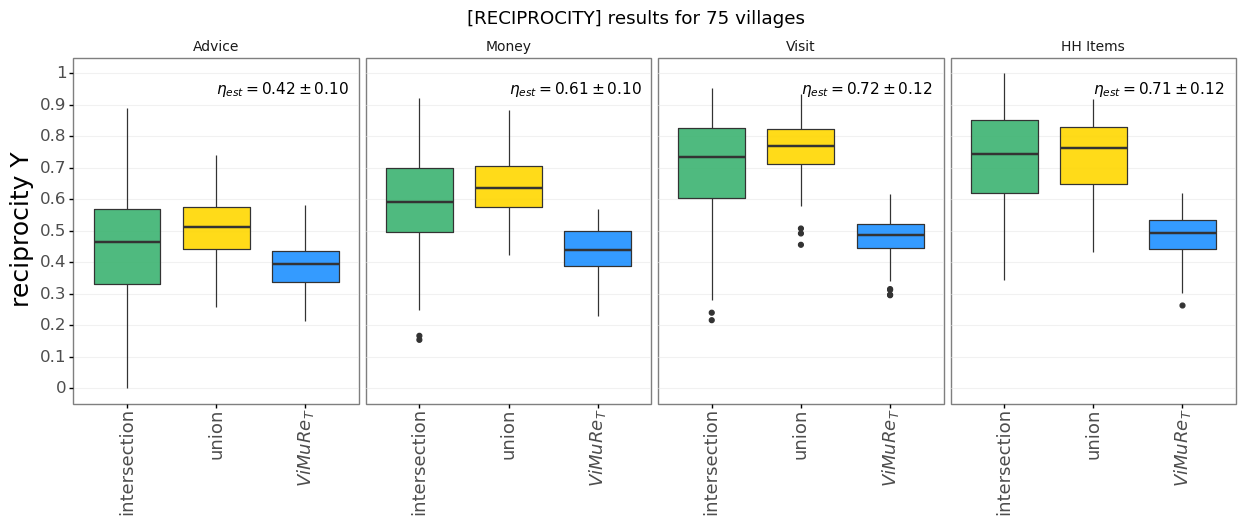

<ggplot: (8774475218999)>

In [261]:
g = plot_network_stat(plot_df, "reciprocity", annotation_df=annotation_df)

ggsave(g + ggtitle(""), filename="/mnt/data/output/real_data/karnataka_villages/vimure_karnataka_reciprocity.png")

g

# Plot: compare networks' transitivity

/opt/conda/lib/python3.9/site-packages/plotnine/scales/scale_manual.py:38: PlotnineWarning: Palette can return a maximum of 3 values. 5 were requested from it.


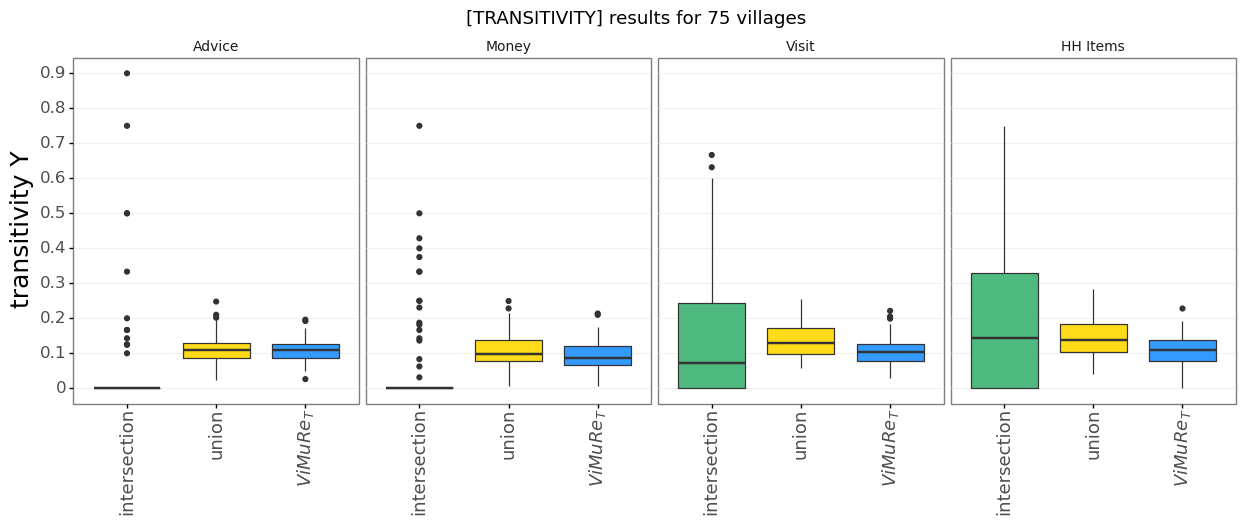

<ggplot: (8774500275119)>

,village,layer,initial_seed,aggregation,num_nodes,num_edges,num_strongly_components,num_weakly_components,avg_out_degree,transitivity,reciprocity,model
0,vil1,Advice,4,union,203,341,93,28,1.679803,0.142157,0.463343,union
1,vil1,Advice,4,intersection,203,19,198,189,0.093596,0.000000,0.526316,intersection
2,vil1,Advice,4,vimure,203,319,110,28,1.571429,0.133333,0.407524,$ViMuRe_{T}$
3,vil1,HH Items,6,union,203,360,71,38,1.773399,0.051148,0.811111,union
4,vil1,HH Items,6,intersection,203,19,196,191,0.093596,0.000000,0.736842,intersection
...,...,...,...,...,...,...,...,...,...,...,...,...
1279,vil9,HH Items,-1,Incoming,198,231,170,12,1.166667,0.143836,0.181818,Incoming
1280,vil9,Advice,-1,Incoming,192,187,174,31,0.973958,0.033708,0.171123,Incoming
1281,vil9,Money,-1,Outgoing,184,190,173,23,1.032609,0.065421,0.115789,Outgoing
1282,vil9,Visit,-1,Outgoing,204,246,181,13,1.205882,0.061275,0.170732,Outgoing


In [197]:
plot_network_stat(plot_df, "transitivity")

# Plot: Average out degree

/opt/conda/lib/python3.9/site-packages/plotnine/scales/scale_manual.py:38: PlotnineWarning: Palette can return a maximum of 3 values. 5 were requested from it.


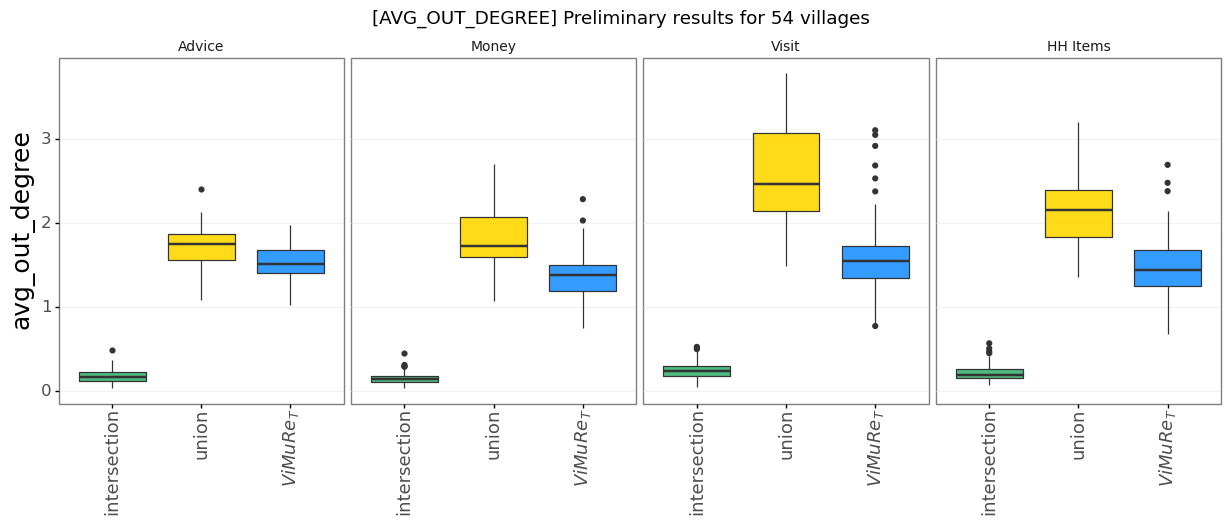

<ggplot: (8774475455748)>

In [209]:
g = (ggplot(distances_df, aes(x="value", fill="layer_comb", color="layer_comb")) + 
     geom_density(alpha=0.05, size=2.6) + 
     theme_matplotlib() +
     scale_fill_manual(name="Layer - Layer", values=COLORS) +
     scale_color_manual(name="Layer - Layer", values=COLORS) +
     theme(figure_size=(12, 8),
           axis_title_x=element_text(size=15),
           axis_title_y=element_text(size=15),
           axis_text_x=element_text(size=12),
           axis_text_y=element_text(size=12),
           subplots_adjust={'wspace': 0.25}) +
     xlab('Distance'+ r'$(\theta^{\ell_1},\theta^{\ell_2})$') +
     scale_y_continuous(name='Density'))

# ggsave(g, "/mnt/data/output/real_data/karnataka_villages/vimure_karnataka_theta_correlation_histograms.pdf")

g

# Plot: compare network density

/opt/conda/lib/python3.9/site-packages/plotnine/scales/scale_manual.py:38: PlotnineWarning: Palette can return a maximum of 3 values. 5 were requested from it.


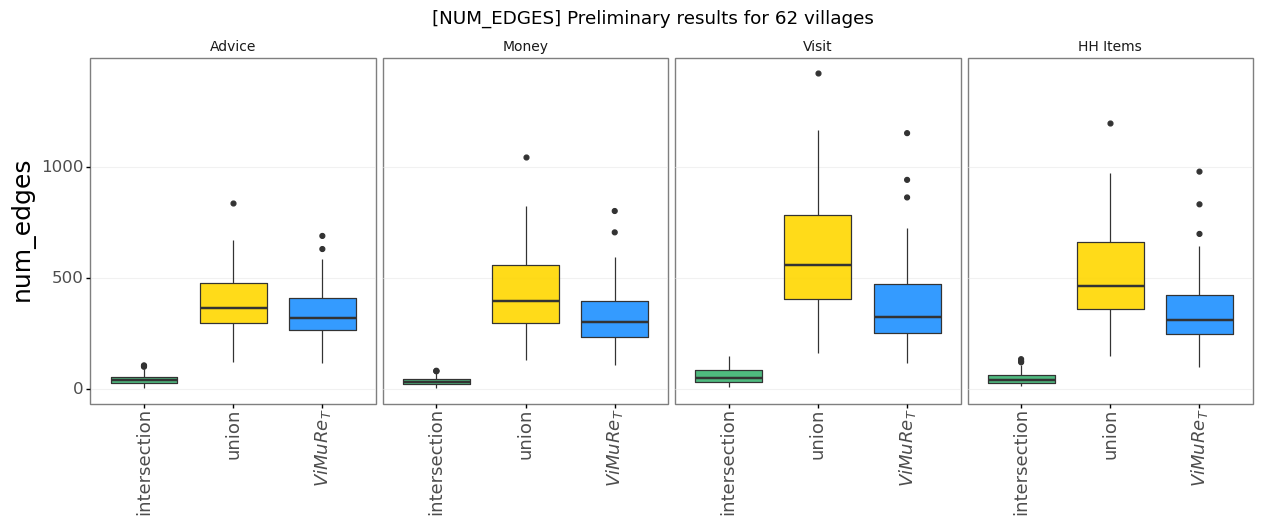

<ggplot: (8777064669727)>

In [42]:
plot_network_stat(plot_df, "num_edges")

# Plot: compare connected components

## Number of strongly connected compoments

/opt/conda/lib/python3.9/site-packages/plotnine/scales/scale_manual.py:38: PlotnineWarning: Palette can return a maximum of 3 values. 5 were requested from it.


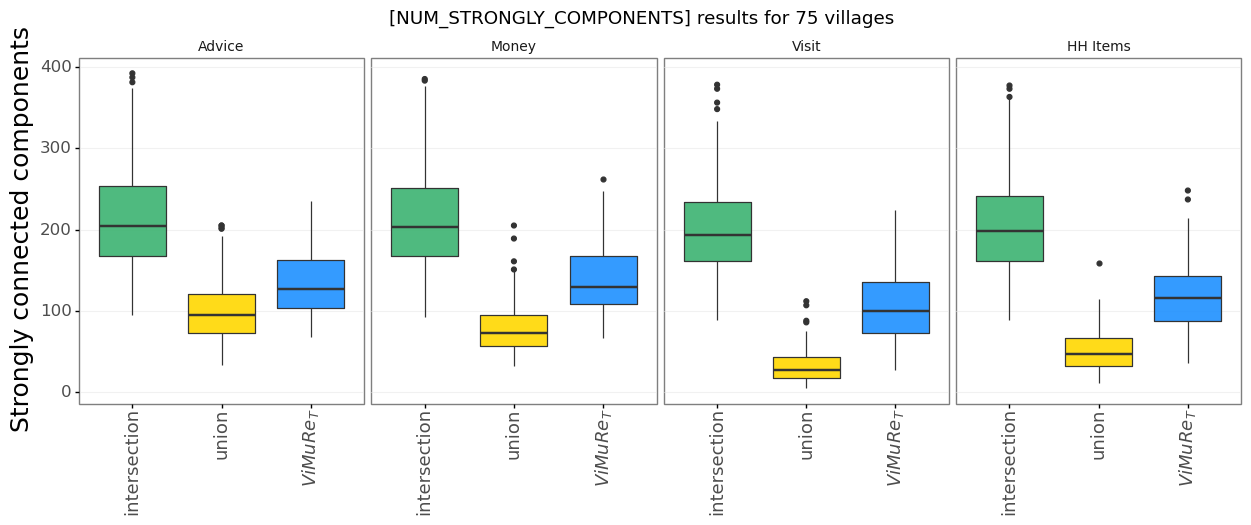

<ggplot: (8774508554487)>

In [199]:
plot_network_stat(plot_df, "num_strongly_components") + ylab("Strongly connected components")

## Number of weakly connected components

/opt/conda/lib/python3.9/site-packages/plotnine/scales/scale_manual.py:38: PlotnineWarning: Palette can return a maximum of 3 values. 5 were requested from it.


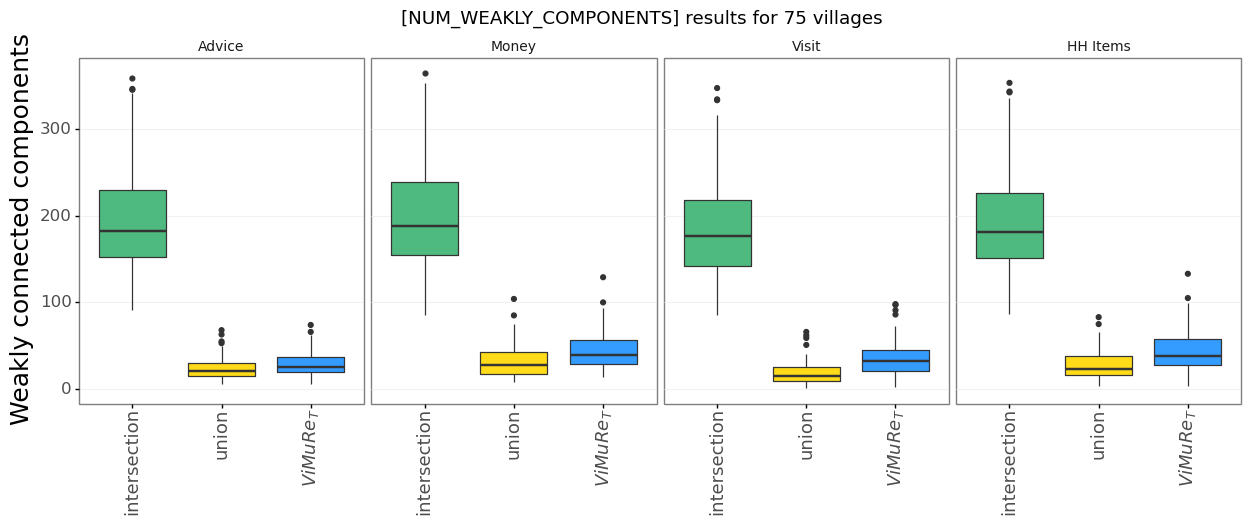

<ggplot: (8774506418984)>

In [200]:
plot_network_stat(plot_df, "num_weakly_components") + ylab("Weakly connected components")

# Plot: compare reliabilities

In [463]:
def reliability_summary(df):
    aux_df = df_reliability.groupby(["village"]).apply(lambda x: pd.Series({"pctg_reporters": x["is_node_reporter"].sum()/len(x)}))
    aux_df = df_pctg_reporters["pctg_reporters"].describe()[["mean", "std"]]
    
    filtered_df = df[(df["is_node_reporter"])].copy()
    eps = 0.001
    filtered_df["is_zero"] = filtered_df["lambda_theta"] < eps
    
    aux_df2 = filtered_df.groupby(["village"]).apply(lambda x: pd.Series({"num_zeros": x["is_zero"].sum()/(len(x))}))["num_zeros"].describe()[["mean", "std"]]
    aux_df3 = filtered_df[~filtered_df["is_zero"]]["lambda_theta"].describe()[["mean", "std"]]
    
    return pd.DataFrame({"lambda_theta": [0.26]*3,
                         "y" : [9000, 7500, 6000],
                         "label": ["Avg. % pop surveyed\t\t\t\t " + r"$\rightarrow \quad %.2f \pm %.2f$" % (100*aux_df["mean"], 100*aux_df["std"]),
                                   r"Avg. % of respondants with $(\theta=0$)" + "\t\t" + r"$\rightarrow \quad %.2f \pm %.2f$" % (100*aux_df2["mean"], 100*aux_df2["std"]),
                                   r"Distribution mean (only those $\theta \neq 0$)" + "\t     " + r"$\rightarrow \quad %.2f \pm %.2f$" % (aux_df3["mean"], aux_df3["std"])]})
                          
    
#### Construct a DataFrame with annotation to the plot
    
annotation_df = df_reliability.groupby(["layer"]).apply(reliability_summary).reset_index()
annotation_df["layer"] = pd.Categorical(annotation_df["layer"], categories=["advice", "money", "visit", "kerorice"], ordered=True)
annotation_df["layer"].cat.rename_categories({"advice": "Advice", "money": "Money", "visit": "Visit", "kerorice": "HH Items"}, inplace=True)
annotation_df

,layer,level_1,lambda_theta,y,label
0,Advice,0,0.26,9000,Avg. % pop surveyed\t\t\t\t $\rightarrow \quad...
1,Advice,1,0.26,7500,Avg. % of respondants with $(\theta=0$)\t\t$\r...
2,Advice,2,0.26,6000,Distribution mean (only those $\theta \neq 0$)...
3,HH Items,0,0.26,9000,Avg. % pop surveyed\t\t\t\t $\rightarrow \quad...
4,HH Items,1,0.26,7500,Avg. % of respondants with $(\theta=0$)\t\t$\r...
5,HH Items,2,0.26,6000,Distribution mean (only those $\theta \neq 0$)...
6,Money,0,0.26,9000,Avg. % pop surveyed\t\t\t\t $\rightarrow \quad...
7,Money,1,0.26,7500,Avg. % of respondants with $(\theta=0$)\t\t$\r...
8,Money,2,0.26,6000,Distribution mean (only those $\theta \neq 0$)...
9,Visit,0,0.26,9000,Avg. % pop surveyed\t\t\t\t $\rightarrow \quad...


/opt/conda/lib/python3.9/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Saving 9 x 9 in image.
/opt/conda/lib/python3.9/site-packages/plotnine/ggplot.py:722: PlotnineWarning: Filename: /mnt/data/output/real_data/karnataka_villages/vimure_distribution_reliability.pdf


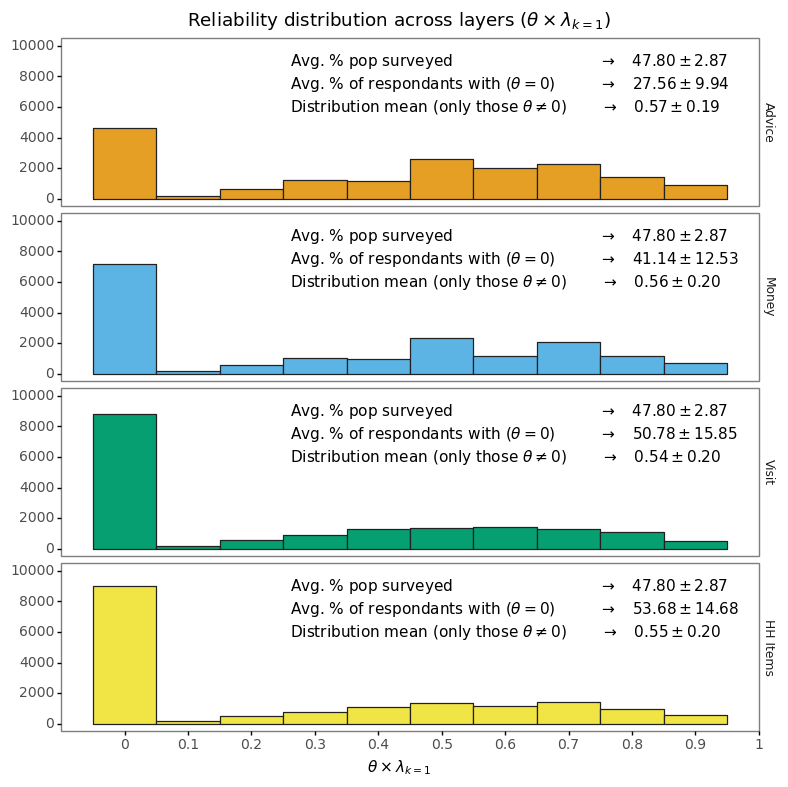

<ggplot: (8774506522534)>

In [466]:
plot_df = df_reliability[df_reliability["is_node_reporter"]].copy()
plot_df["layer"] = pd.Categorical(plot_df["layer"], categories=["advice", "money", "visit", "kerorice"], ordered=True)

plot_df["layer"].cat.rename_categories({"advice": "Advice", "money": "Money", "visit": "Visit", "kerorice": "HH Items"}, inplace=True)

g = (ggplot(plot_df, 
            aes(x="lambda_theta", fill="layer")) +
     geom_histogram(binwidth=0.1, color="#212121") +
     geom_text(mapping=aes(y="y", label="label"), ha='left', data=annotation_df) +
     theme_bw() + 
     scale_fill_manual(values=COLORS, guide=False) +
     theme(figure_size=(9, 9),
           axis_text_x=element_text(size=10),
           axis_text_y=element_text(size=10),
           panel_grid_minor=element_blank(),
           panel_grid_major=element_blank(),           
           strip_background = element_blank(),
           strip_text_x = element_text(size=10),
           axis_title_y=element_text(size=18)) +
     scale_x_continuous(name=r"$\theta \times \lambda_{k=1}$", breaks=np.arange(0, 1.1, 0.1)) +
     scale_y_continuous(name="", breaks=np.arange(0, 12000, 2000), limits=(0, 10000)) +
     facet_grid("layer ~ .", labeller="label_value", scales="free_y") + 
     ggtitle(r"Reliability distribution across layers ($\theta \times \lambda_{k=1}$)"))

# ggsave(g + ggtitle(""), "/mnt/data/output/real_data/karnataka_villages/vimure_distribution_reliability.pdf")

g

# Plot: indegree vs reliability

In [543]:
def get_net_indegree_df(G, aggregation_name):
    # Avg number of nominations (outgoing edges) per reporter
    in_degrees = [d for _, d in G.in_degree()]

    return pd.DataFrame({"aggregation":     aggregation_name,
                         "node": list(G.nodes()),
                         "indegree": in_degrees
                        }) 

def get_indegrees(df_edgelist):

    village = df_edgelist["village"].values[0]
    layer = df_edgelist["layer"].values[0]    
    
    relevant_columns = ["source", "target", "weight"]
    
    filtered_edgelist = df_edgelist[(df_edgelist["is_source_reporter"] & df_edgelist["is_target_reporter"])]

    # Vimure takes full sample into account 
    tmp = filtered_edgelist[(filtered_edgelist["in_vimure"])]
    G_vimure = nx.from_pandas_edgelist(tmp[relevant_columns], create_using=nx.DiGraph)
    G_vimure.remove_edges_from(nx.selfloop_edges(G_vimure))
    df_vimure = get_net_indegree_df(G_vimure, aggregation_name="vimure")
    
    return df_vimure

plot_df = df_bigger_edgelist.groupby(["village", "layer", "initial_seed"]).progress_apply(get_indegrees)
plot_df.reset_index(inplace=True)
plot_df.drop(columns=["level_3"], inplace=True)

plot_df = pd.merge(plot_df, df_reliability[["village", "layer", "node", "lambda_theta"]])
plot_df["layer"] = pd.Categorical(plot_df["layer"], categories=["advice", "money", "visit", "kerorice"], ordered=True)

plot_df["layer"].cat.rename_categories({"advice": "Advice", "money": "Money", "visit": "Visit", "kerorice": "HH Items"}, inplace=True)
plot_df.head()

  0%|          | 0/300 [00:00<?, ?it/s]

,village,layer,initial_seed,aggregation,node,indegree,lambda_theta
0,vil1,Advice,4,vimure,0,0,0.737093
1,vil1,Advice,4,vimure,107,4,0.000007
2,vil1,Advice,4,vimure,1,0,0.737009
3,vil1,Advice,4,vimure,4,0,0.506560
4,vil1,Advice,4,vimure,3,2,0.736940


/opt/conda/lib/python3.9/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Saving 10 x 3 in image.
/opt/conda/lib/python3.9/site-packages/plotnine/ggplot.py:722: PlotnineWarning: Filename: /mnt/data/output/real_data/karnataka_villages/vimure_karnataka_indegree_vs_reliability.png


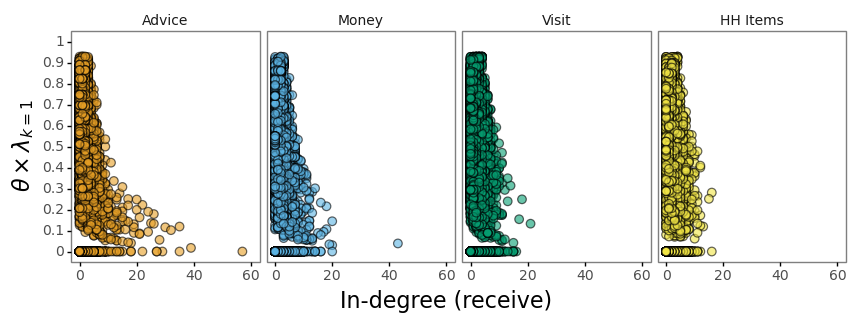

<ggplot: (8774506254499)>

In [557]:
g = (ggplot(plot_df, aes(x="indegree", y="lambda_theta")) + 
     geom_point(aes(fill="layer"), size=3, alpha=0.6) + 
     theme_bw() +
     scale_fill_manual(values=COLORS, guide=False) +
     theme(figure_size=(10, 3),
           axis_text_x=element_text(size=10),
           axis_text_y=element_text(size=10),
           panel_grid_minor=element_blank(),
           panel_grid_major=element_blank(),           
           strip_background = element_blank(),
           strip_text_x = element_text(size=10),
           axis_title=element_text(size=16)) +
     scale_x_continuous(name="In-degree (receive)", breaks=np.arange(0, 60+20, 20), limits=(0, 60)) +
     scale_y_continuous(name=r"$\theta \times \lambda_{k=1}$", breaks=np.arange(0, 1.2, 0.1), limits=(0, 1)) + 
     facet_wrap("~ layer", ncol=4))

ggsave(g + ggtitle(""), "/mnt/data/output/real_data/karnataka_villages/vimure_karnataka_indegree_vs_reliability.png")


g

# Plot: compare networks' reciprocity

From here on, we don't need to plot the original layers:

In [567]:
plot_df = plot_df[plot_df["model"].isin(["intersection", "union", r"$ViMuRe_{T}$"])].copy()

In [204]:
#https://stackoverflow.com/a/49271098/843365

all_combs = pd.DataFrame([
    [n, x, y]
    for n, g in plot_df.groupby(["village"]).layer
    for x, y in itertools.combinations(df_reliability["layer"].unique(), 2)], 
    columns=['village', 'layer1', 'layer2'])

all_combs

village    layer1    layer2
0      vil1    advice  kerorice
1      vil1    advice     money
2      vil1    advice     visit
3      vil1  kerorice     money
4      vil1  kerorice     visit
..      ...       ...       ...
445    vil9    advice     money
446    vil9    advice     visit
447    vil9  kerorice     money
448    vil9  kerorice     visit
449    vil9     money     visit

[450 rows x 3 columns]

## Annotate $\eta_{est}$ in the plot

In [578]:
annotation_df = df_model_summary.groupby(["layer"])["eta_est"].describe()[["mean", "std"]].reset_index()
annotation_df["layer"] = pd.Categorical(annotation_df["layer"], categories=["advice", "money", "visit", "kerorice"], ordered=True)
annotation_df["layer"].cat.rename_categories({"advice": "Advice", "money": "Money", "visit": "Visit", "kerorice": "HH Items"}, inplace=True)

def calculate_distances(village, layer1, layer2, df_reliability=df_reliability):
    
    reliabilities_layer1 = df_reliability.query(query_str % (village, layer1))["lambda_theta"]
    reliabilities_layer2 = df_reliability.query(query_str % (village, layer2))["lambda_theta"]
    
    try:
        wasserstein = sp.stats.wasserstein_distance(reliabilities_layer1, reliabilities_layer2)
    except:
        wasserstein = None
        
    return pd.Series({"wasserstein": wasserstein})
#                       "cosine": cosine,
#                       "pearson": pearson})

distances_df = pd.concat([all_combs, 
                          all_combs.progress_apply(lambda x: calculate_distances(village=x[0], layer1=x[1], layer2=x[2]), axis=1)],
                         axis=1)
distances_df = pd.melt(distances_df, id_vars=["village", "layer1", "layer2"], var_name="distance_metric")


distances_df["layer1"] = pd.Categorical(distances_df["layer1"], categories=["advice", "money", "visit", "kerorice"], ordered=True)
distances_df["layer1"].cat.rename_categories({"advice": "Advice", "money": "Money", "visit": "Visit", "kerorice": "HH Items"}, inplace=True)

distances_df["layer2"] = pd.Categorical(distances_df["layer2"], categories=["advice", "money", "visit", "kerorice"], ordered=True)
distances_df["layer2"].cat.rename_categories({"advice": "Advice", "money": "Money", "visit": "Visit", "kerorice": "HH Items"}, inplace=True)

distances_df["layer_comb"] = distances_df["layer1"].astype(str) + " - " + distances_df["layer2"].astype(str)

distances_df

  0%|          | 0/450 [00:00<?, ?it/s]

,village,layer1,layer2,distance_metric,value,layer_comb
0,vil1,Advice,HH Items,wasserstein,0.070123,Advice - HH Items
1,vil1,Advice,Money,wasserstein,0.027818,Advice - Money
2,vil1,Advice,Visit,wasserstein,0.036940,Advice - Visit
3,vil1,HH Items,Money,wasserstein,0.042483,HH Items - Money
4,vil1,HH Items,Visit,wasserstein,0.034430,HH Items - Visit
...,...,...,...,...,...,...
445,vil9,Advice,Money,wasserstein,0.029529,Advice - Money
446,vil9,Advice,Visit,wasserstein,0.064711,Advice - Visit
447,vil9,HH Items,Money,wasserstein,0.056970,HH Items - Money
448,vil9,HH Items,Visit,wasserstein,0.021977,HH Items - Visit


/opt/conda/lib/python3.9/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Saving 12 x 8 in image.
/opt/conda/lib/python3.9/site-packages/plotnine/ggplot.py:722: PlotnineWarning: Filename: /mnt/data/output/real_data/karnataka_villages/vimure_karnataka_theta_correlation_histograms.pdf


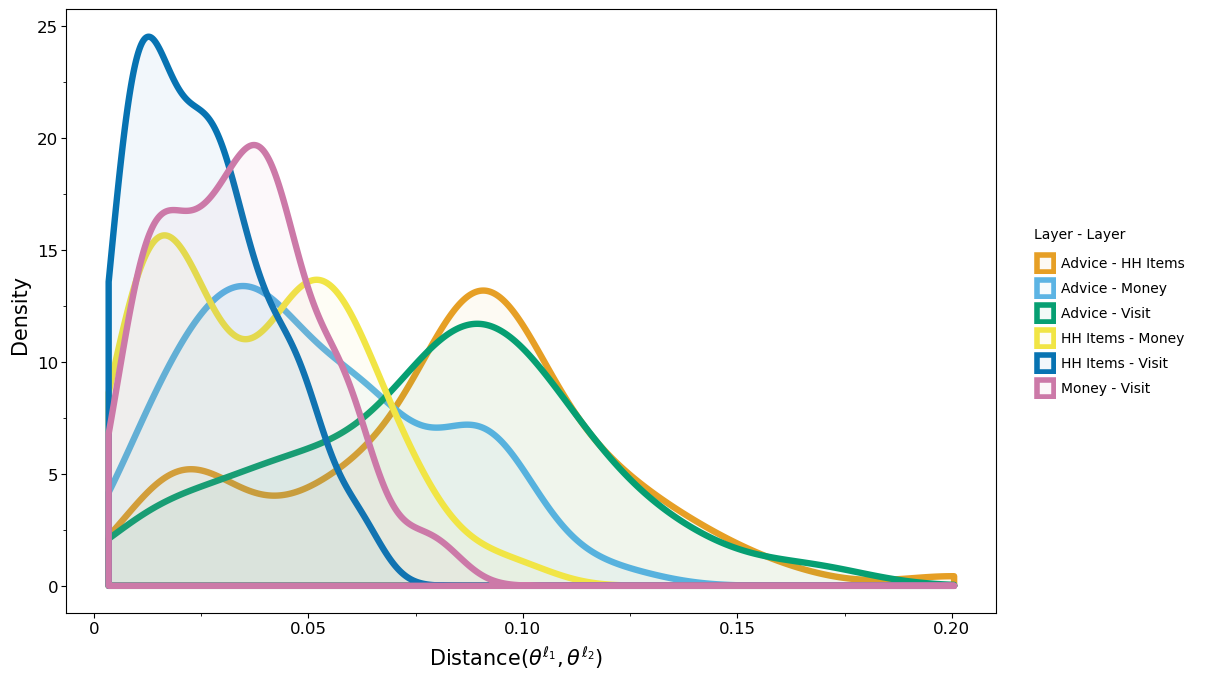

<ggplot: (8727333215305)>

In [581]:
plot_network_stat(plot_df, "transitivity")

# Plot: Average out degree

/opt/conda/lib/python3.9/site-packages/plotnine/scales/scale_manual.py:38: PlotnineWarning: Palette can return a maximum of 3 values. 5 were requested from it.


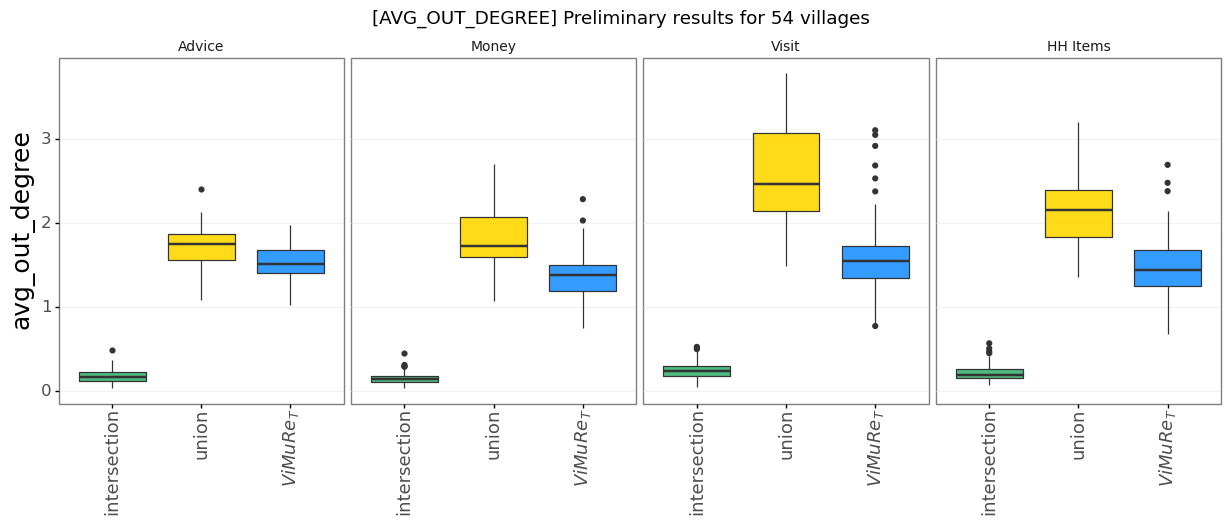

<ggplot: (8774475455748)>

In [209]:
g = (ggplot(distances_df, aes(x="value", fill="layer_comb", color="layer_comb")) + 
     geom_density(alpha=0.05, size=2.6) + 
     theme_matplotlib() +
     scale_fill_manual(name="Layer - Layer", values=COLORS) +
     scale_color_manual(name="Layer - Layer", values=COLORS) +
     theme(figure_size=(12, 8),
           axis_title_x=element_text(size=15),
           axis_title_y=element_text(size=15),
           axis_text_x=element_text(size=12),
           axis_text_y=element_text(size=12),
           subplots_adjust={'wspace': 0.25}) +
     xlab('Distance'+ r'$(\theta^{\ell_1},\theta^{\ell_2})$') +
     scale_y_continuous(name='Density'))

# ggsave(g, "/mnt/data/output/real_data/karnataka_villages/vimure_karnataka_theta_correlation_histograms.pdf")

g